In [93]:
!eval "$(/clusterfs/ml4hep_nvme2/bpnachman/anaconda3/bin/conda shell.bash hook)"
!conda activate ml4hep2


import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseRationalQuadraticAutoregressiveTransform

from nflows.transforms.permutations import ReversePermutation

/bin/bash: line 1: /clusterfs/ml4hep_nvme2/bpnachman/anaconda3/bin/conda: No such file or directory

CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




## Define the target probability density

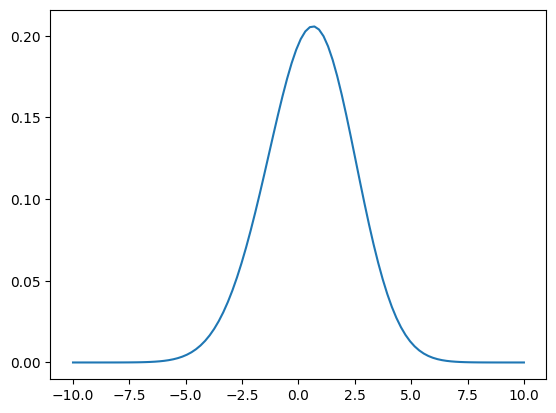

In [94]:
# gaussian distribution
sigmasq = 3
mean = 3

def target_p(x):

    gaussian1 = (1.0/(np.sqrt(2*np.pi*sigmasq)))*torch.exp(-0.5*(x-mean)**2/sigmasq)
    gaussian2 = (1.0/(np.sqrt(2*np.pi*sigmasq)))*torch.exp(-0.5*(x+mean)**2/sigmasq)
    

    return  1*gaussian1 + 0.0*gaussian2


x = torch.linspace(-10, 10, steps = 100)

plt.figure()
plt.plot(x, target_p(x))
plt.show()


# Define the flow architecture

Standard flow training is $z = f(x)$ for physical variable $x$, latent variable $z$. In this case, the loss would be `loss = -flow.log_prob(inputs=x).mean()`, so we assume that we have physical samples $x$.

On our case, we know the target $p(x)$, and we don't have samples. We want `loss = calc_dkl(logp, logq)`, where the $q$ represents the flow action. 

With nflows, because we have a base distribution, we still *must* transform from $x$ to $z$. 



In [95]:
# Loss function
def calc_dkl(logp, logq, train_from_samples):

    if train_from_samples:
        return -(logp - logq).sum(dim = 1).mean()# reverse KL, assuming samples from q
        
    else:
        return -(logp.exp()*(logq - logp)).sum(dim = 1).mean()# reverse KL, assuming samples from q

In [96]:
base_dist = StandardNormal(shape=[1])

num_layers = 4
num_hidden_features = 128 # relaed to network width
num_blocks = 10 # related to network depth
num_bins = 10 # essentially how many piecewise splines we want
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=1))
    transforms.append(MaskedAffineAutoregressiveTransform(features=1, hidden_features = 128))
    #transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features = 1, 
    #                                   hidden_features = num_hidden_features, num_blocks = num_blocks, tail_bound = 5, 
     #                                              num_bins = num_bins, tails = "linear"))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters(), lr = 0.001)


In [97]:
from tqdm import tqdm

num_epochs = 200
train_losses = []

batch_size = 512

train_from_samples = False


def correct_f(z):
    return z*np.sqrt(sigmasq) + mean

def correct_f_inv(x):
    return (x - mean)/np.sqrt(sigmasq)

def correct_dx_dz(z):
    return np.sqrt(sigmasq)

def correct_dz_dx(x):
    return 1/np.sqrt(sigmasq)



for i in tqdm(range(num_epochs)):
    
    optimizer.zero_grad()
    
    if train_from_samples:
        
        # SAMPLE FROM THE PRIOR z
        z_samples = flow._distribution.sample(batch_size) 
        
        # APPLY FLOW TO PRIOR
        logp_of_z = flow._distribution.log_prob(z_samples)
        x_samples, log_dx_dz = flow._transform(z_samples)
        logq = logp_of_z - log_dx_dz
        

    else:
        
        # PULL VALUES OF x
        # x_samples = torch.linspace(-10, 10, steps = batch_size).reshape(-1,1)

        # Random uniform noise
        x_samples = torch.rand(batch_size, 1)*20 - 10
    
        # APPLY INVERSE FLOW TO x
        z_samples, log_dz_dx = flow._transform.inverse(x_samples)
        log_p_of_z = flow._distribution.log_prob(z_samples) 

        # # x_samples = torch.normal(mean, np.sqrt(sigmasq), (batch_size, 1))
        # z_samples = correct_f_inv(x_samples)
        # log_dz_dx = np.log(correct_dz_dx(x_samples))
        # log_p_of_z = flow._distribution.log_prob(z_samples) 




        # test_z = torch.rand(1000, 1)*20 - 10
        # test_x_samples = correct_f(test_z)
        # plt.plot(test_z.detach().numpy(), test_x_samples.detach().numpy(), 'o')
        # plt.plot(test_z, test_z*np.sqrt(sigmasq) + mean, 'r')

        logq = log_p_of_z + log_dz_dx
        logq = torch.reshape(logq, (-1, 1)) # KEY FIX FOR TRAINING ISSUE
        
        
    logp = torch.log(target_p(x_samples))
    loss = calc_dkl(logp, logq, train_from_samples)


    # plt.plot(x_samples.detach().cpu().numpy(), logq.detach().cpu().numpy(), 'o', alpha = 0.5)
    # plt.plot(x_samples.detach().cpu().numpy(), logp.detach().cpu().numpy(), 'x', alpha = 0.5)
    # plt.xlim(-5, 5)


    plt.show()
    
    loss.backward()
    optimizer.step()
        
    train_losses.append(loss.detach().cpu().numpy())
    

    

100%|██████████| 200/200 [00:03<00:00, 63.51it/s]


[array(4.030036, dtype=float32), array(1.0738918, dtype=float32), array(0.23326747, dtype=float32), array(0.04485097, dtype=float32), array(0.00693027, dtype=float32), array(0.00500826, dtype=float32), array(0.0181056, dtype=float32), array(0.02759082, dtype=float32), array(0.04055503, dtype=float32), array(0.05654452, dtype=float32), array(0.06165037, dtype=float32), array(0.06918462, dtype=float32), array(0.06402691, dtype=float32), array(0.08224092, dtype=float32), array(0.08155381, dtype=float32), array(0.08363599, dtype=float32), array(0.09218934, dtype=float32), array(0.09332118, dtype=float32), array(0.1112282, dtype=float32), array(0.09514286, dtype=float32), array(0.09122337, dtype=float32), array(0.09661138, dtype=float32), array(0.09328546, dtype=float32), array(0.09350538, dtype=float32), array(0.0826664, dtype=float32), array(0.08231566, dtype=float32), array(0.09476717, dtype=float32), array(0.06372173, dtype=float32), array(0.06660032, dtype=float32), array(0.05811039, d

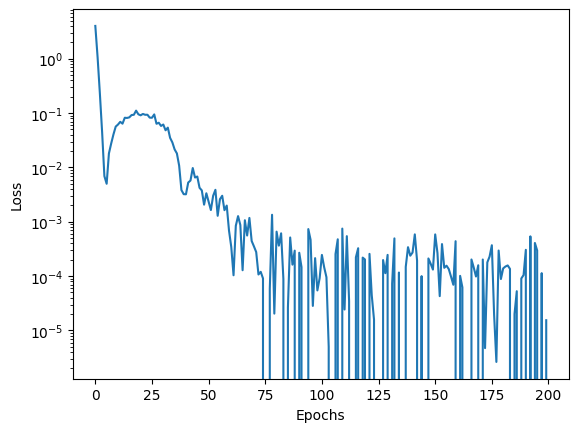

In [98]:
plt.figure()
plt.plot(train_losses)
print(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()



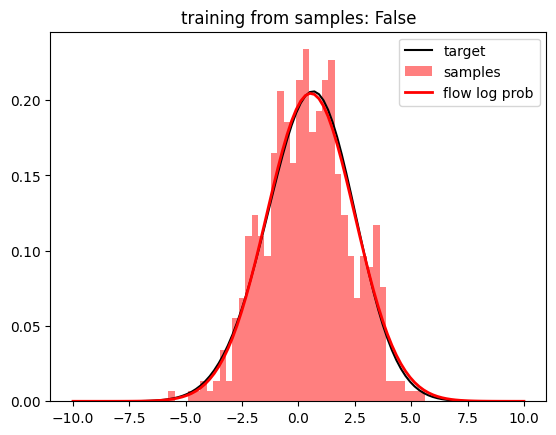

In [99]:

plt.figure()

# plot target
x_test = torch.linspace(-10, 10,steps = 100).reshape(-1,1)
plt.plot(x_test, target_p(x_test), label = "target", color = "black")

# plot flow samples
z_samples = flow._distribution.sample(batch_size) 
x, _ = flow._transform(z_samples)  
plt.hist(x.detach().cpu().numpy().reshape(-1,), bins = 40, density = True, label = "samples", color = "red", alpha = 0.5)

# plot flow log prob
z, dz_dx = flow._transform.inverse(x_test)  
px = (flow._distribution.log_prob(z) + dz_dx).exp()
plt.plot(x_test.detach().cpu().numpy(), px.detach().cpu().numpy(), label = "flow log prob", color = "red", lw = 2)

plt.legend()
plt.title("training from samples: "+str(train_from_samples))
plt.show()
